#Housing Prices Prediction using various Regression Techniques
###Problem Description: 
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

###Import Libraries:

In [651]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline 
#Enable Iniline Plotting
import matplotlib.pyplot as plt
from scipy.stats import skew

###Import Data:

In [652]:
traindata=pd.read_csv('../data/train.csv')
traindata=traindata.loc[:,'MSSubClass':'SalePrice']
traindata.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Normalise the skewed data by using log transform. When data is skewed mean normalization is not helpful and log transformation helps to get a data with less skewness. In this case we will calculate log(1+feature)

In [653]:

#log transform the target:
traindata["SalePrice"] = np.log1p(traindata["SalePrice"])

#log transform skewed numeric features:
numeric_feats = traindata.dtypes[traindata.dtypes != "object"].index

skewed_feats = traindata[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

traindata[skewed_feats] = np.log1p(traindata[skewed_feats])


Now we convert categorical features using bit pair encoding. And then generate the X and y datasets.
####Converting Train Data to two data sets
* Training Set
* Test Set

In [654]:
traindata=pd.get_dummies(traindata)

#Remove NaN with mean of the values
traindata=traindata.fillna(traindata.mean())

#Shuffle the data
traindata = traindata.sample(frac=1).reset_index(drop=True)

#Generate  X and y datasets

#Make 20% of the Data Test Set for evaluating the different models
testsize=int(traindata.shape[0]*0.8)
X=traindata.iloc[0:testsize,:(traindata.shape[1]-1)]
y=traindata[0:testsize]
y=y.loc[:,"SalePrice"]
Xtest=traindata.iloc[testsize+1:,:(traindata.shape[1]-1)]
ytest=traindata[testsize+1:]
ytest=ytest.loc[:,"SalePrice"]



###Training using CART Trees
First we will train the model using CART decision Trees.

In [655]:
from sklearn import tree
regressorCART=tree.DecisionTreeRegressor()
regressorCART=regressorCART.fit(X,y)

Plotting the error of the actual value (y is in mormalized form)

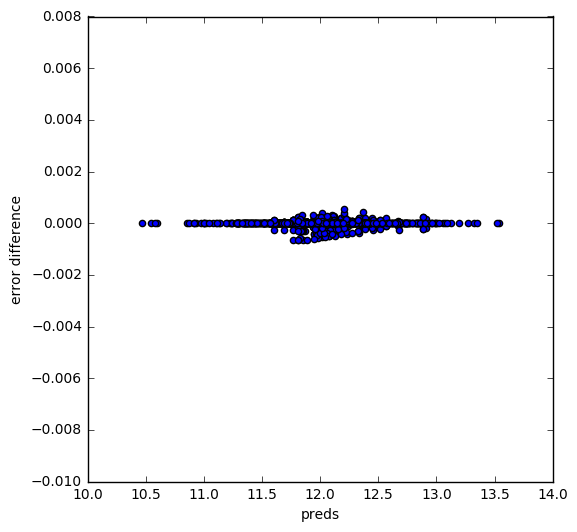

In [656]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":regressorCART.predict(X), "true":y})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

####Visualizing the Decision Tree

In [657]:
'''
import pydotplus 
dot_data = tree.export_graphviz(regressorCART, out_file=None, 
                         feature_names=list(X.columns.values),  
                         class_names='SalesPrice' , 
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_pdf("iris.pdf") 
'''

'\nimport pydotplus \ndot_data = tree.export_graphviz(regressorCART, out_file=None, \n                         feature_names=list(X.columns.values),  \n                         class_names=\'SalesPrice\' , \n                         filled=True, rounded=True,  \n                         special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data)  \ngraph.write_pdf("iris.pdf") \n'

###Training using Random Forest

In [658]:
from sklearn.ensemble import RandomForestRegressor
regressorRandomForest=RandomForestRegressor(n_estimators=10)
regressorRandomForest=regressorRandomForest.fit(X,y)

Plotting the error in prediction

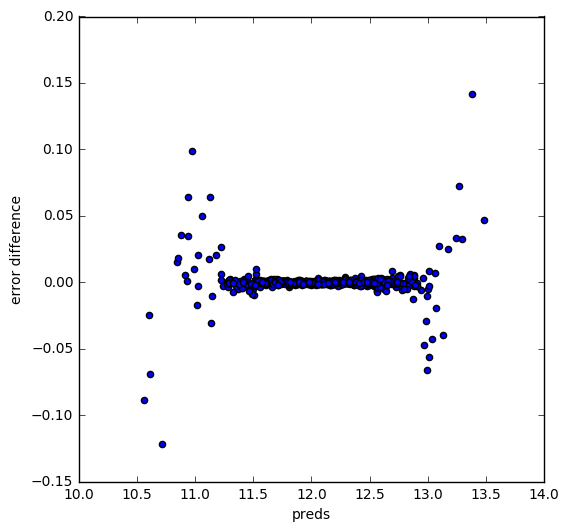

In [659]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":regressorRandomForest.predict(X), "true":y})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

###Training using Linear Regression
We will now use regularzed linear Regression to Train the model. First we need to determine the value of lambda (the regularization parameter). We will calculate the root mean square error using different values of labda.

In [660]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, cross_val_predict




alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge=RidgeCV(alphas=alphas)
cv_ridge=cv_ridge.fit(X,y)
cv_ridge.alpha_

0.050000000000000003

In [661]:
regressorRidge = Ridge(alpha=cv_ridge.alpha_)
regressorRidge=regressorRidge.fit(X,y)

####Plot the error

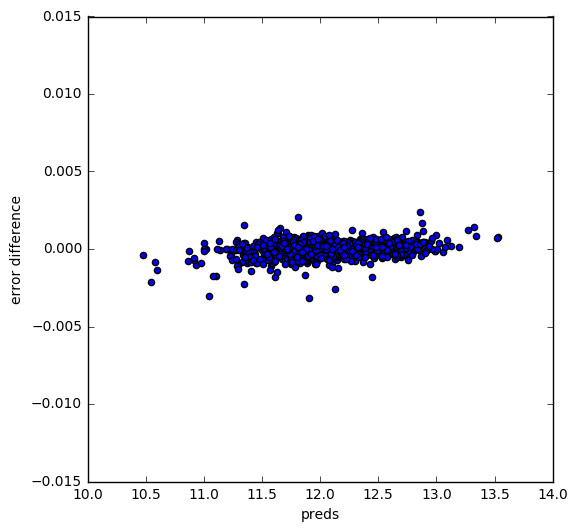

In [662]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":regressorRidge.predict(X), "true":y})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

###Testing different models using the Test Set


In [663]:
#Test Set Preview
Xtest.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal
1169,3.044522,4.207109,9.512443,5,6,1965,1965,4.744932,6.329721,5.929589,...,0,0,0,0,1,0,0,0,0,1
1170,5.081404,3.091042,7.427144,5,5,1971,1971,4.962845,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
1171,3.044522,4.382027,9.130972,6,5,1997,1997,0.000000,7.090910,0.000000,...,0,0,0,0,1,0,0,0,0,1
1172,3.931826,4.369448,9.258845,6,6,1949,1950,5.771441,5.283204,0.000000,...,0,0,0,0,1,0,0,0,0,1
1173,4.510860,4.174387,8.856376,5,5,1979,1979,5.620401,6.991177,0.000000,...,0,0,0,0,1,0,0,1,0,0


####CART Model:

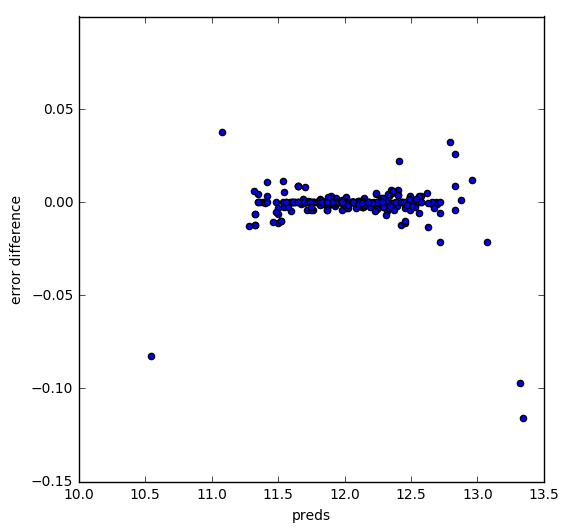

In [664]:
predictedCART =regressorCART.predict(Xtest)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":predictedCART, "true":ytest})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

####Random Forest:

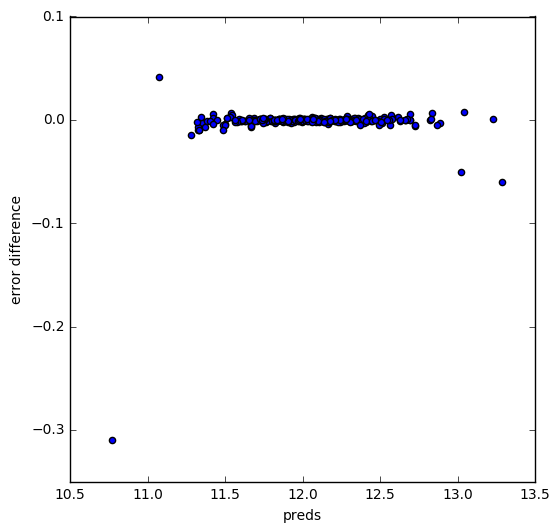

In [665]:
predictedRandomForest = regressorRandomForest.predict(Xtest)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":predictedRandomForest, "true":ytest})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

####Linear Regression using Ridge Regularization

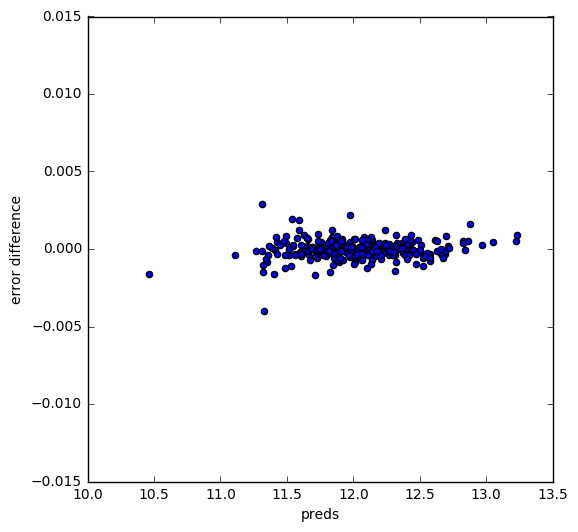

In [666]:
#predictedRidge= cross_val_predict(regressorRidge, Xtest, ytest, cv=10)
predictedRidge=regressorRidge.predict(Xtest)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":predictedRidge, "true":ytest})
preds["error difference"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "error difference",kind = "scatter")

###Calculate the Prediction accuracy for different models

In [667]:

scoreCART=regressorRidge.score(Xtest,ytest)
scoreRandomForest=regressorRandomForest.score(Xtest,ytest)
scoreRidge=regressorRidge.score(Xtest,ytest)
print("CART Accuracy: "+str(scoreCART*100)+"%")
print("Random Forest Accuracy: "+str(scoreRandomForest*100)+"%")
print("Linear Regression(Ridge) Accuracy: "+str(scoreRidge*100)+"%")
modelsScore={scoreCART:"CART",scoreRandomForest:"Random Forest",scoreRidge:"Linear Regression"}
maxScoreModel=modelsScore[max(modelsScore)]
print("Model with Highest Accuracy is: "+maxScoreModel)

CART Accuracy: 99.9997462668%
Random Forest Accuracy: 99.7550399109%
Linear Regression(Ridge) Accuracy: 99.9997462668%
Model with Highest Accuracy is: Linear Regression


###Display Predictions vs Actual  using Linear Regression
Get back the data from log(1+p) form by applying exponentation
####Test Set:

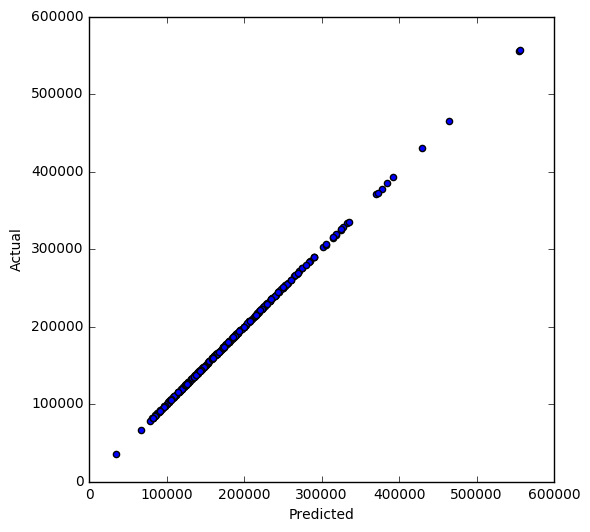

In [668]:
predictedRidge=np.expm1(predictedRidge) #Bring Back the non Log Data
ytest=np.expm1(ytest)

#Plot the Graph
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"Predicted":predictedRidge, "Actual":ytest})
preds.plot(x = "Predicted", y = "Actual",kind = "scatter")

Woah that looks like a pretty amazing prediction lets try the Training Set now!
####Training Set:

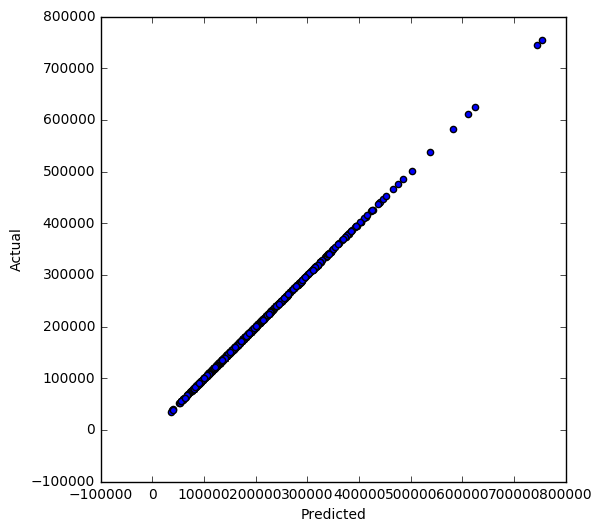

In [669]:
predictedRidgeTrain=np.expm1(regressorRidge.predict(X)) #Bring Back the non Log Data
y=np.expm1(y)

#Plot the Graph
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"Predicted":predictedRidgeTrain, "Actual":y})
preds.plot(x = "Predicted", y = "Actual",kind = "scatter")